# Simulação de Enquadramento na Fábrica de Limites - Crédito parcelado

### Objetivo:


Simular o enquadramento de cooperados do Sicoob Unicentro Br na Fábrica de Limites conforme parâmetros de Política de Crédito que será apresentada para Diretoria. Para a definição desta política foi feita análise exploratória de dados para o desempenho das variáveis observando a quantidade de cadastros, o valor concedido e o Inad30 dos créditos liberados. Posteriormente, este valores foram aplicados em propostas de modelos de perfis para a nova política, tendando individualizar os perfis para identificar grupos de cooperados que não devem estar enquadrados na Fábrica de Limites. 

Diante das informações analisadas, foram propostos perfis médico, separação de cooperados por idade maior e menor que 30 anos e separação por cooperados por tempo de associação, com mais e menos que 3 anos. Os cooperados com renda ponderada, ou seja, cooperados que se associaram no PA digital e a renda atual é a sua primeira renda cadastrada considerando a renda que ele informa e a renda de consulta em bureau, foram cadastrados em perfis separados. Quanto à pessoa jurídica, também foram  separados entre o tempo de associação de 3 anos e pefis por tipo de renda, com renda comprovada e declarada. A seguir, a última tabela analisada com estes perfis:

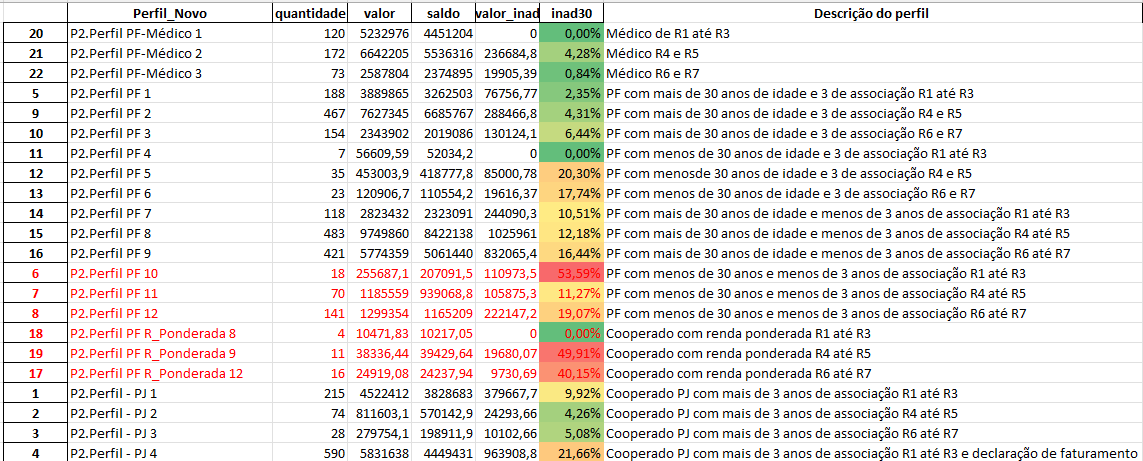

Conforme a tabela acima, os melhores desempenhos estão com cooperados médicos e cooperados com mais de 30 anos de idade e 3 anos de associação. Por outro lado, cooperados menores que 30 anos de idade e 3 anos de associação, também cooperados cadastrados com renda ponderada, são os que apresentam pior desempenho. Sendo assim, **foi proposto não considerar na nova Política de Crédito para a Fábrica de Limites a renda ponderada**. 

* obs: Nem todos os perfis tiveram cooperados da amostra que se enquadraram, sendo que a tabela acima estão apenas perfis com cooperados devedores na amostra.



In [100]:
# Bibliotecas:
import pandas as pd 

In [101]:
# carregar dados:
df = pd.read_parquet(r"data/database/cooperados.parquet")
df2 = pd.read_parquet(r"data/database/dados_cadastrais.parquet")
# anotações 
df3 = pd.read_parquet(r"data/database/anotacao.parquet")
#CRL 
df4 = pd.read_parquet(r"data/database/crl.parquet")

df5 = pd.read_parquet(r"data/database/scr.parquet")

In [102]:
# instanciar variáveis:
coop = df
cliente = df2
anot = df3
crl = df4
scr = df5

## Dados cadastrais 

Os dados cadastrais dos cooperadossão os primeiros filtros da simulação, no qual destacamos a seguir:

### Valor da renda bruta mensal
 Na política atual, há somente um filtro de valor da renda para pessoa físca no valor de um salário mínimo (R$ 1.412,00). Na nova Política de Crédito corrigimos o valor para R$ 1.512,00. 
 
 Ainda sobre o valor da renda bruta mensal, na análise exploratória nota-se uma inadimplência do MEI (Micro Empreendedor Individual) muito maior que a média. Porém, não existe filtro de MEI nos parâmetros da Fábrica de Limites. Sendo assim, para PJ limitamos o valor mínimo de renda/faturamento de R$ 6.750,00 que é o valor máximo para MEI conforme a Lei complementa 123. É importante ressaltar que dos cooperados MEI antigos, alguns possuem faturamento maior que o máximo permitido, porque era praxe aprovar estes cadastros, porém, atualmente os novos cooperados MEI precisam respeitar o teto para a aprovação cadastral. Ou seja, apesar do fitro para MEI, ainda teremos cooperados MEI com possibilidade de tomar crédito na Fábrica de Limites.

 ### Data de atualização cadastral:
 No novo cenário de simulação foi proposto o enquadramento para cooperados com cadastro atualizado até 12 meses. Sendo que no modelo atual o prazo é de 24 meses. Isto porque existe uma correlação forte de aumento de inadimplência conforme o aumento do período em que se aprovou o cadastro da renda

 ### Vínculo empregatício e tipo de renda:
 A seguir os tipos de renda e vínculo empregatício não permitidos:

 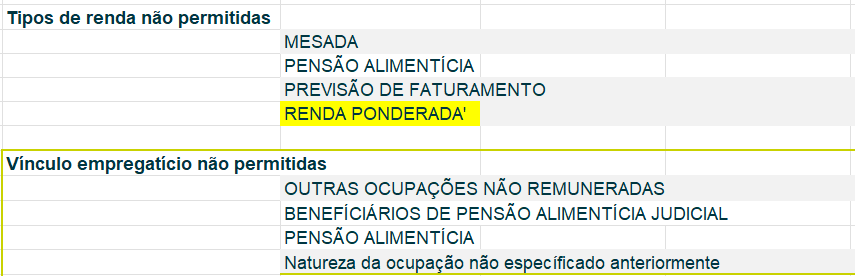

 Com exceção da ***Renda Ponderada*** as demais variáveis já estavam cadastradas como impedidas de tomar crédito na Fábrica de Limites. É necessário excluir a renda ponderda na Fábrica de Limites, pois foi identificado na análise exploratória que este grupo de cooperados são grandes ofensores para o desempenho da carteira. 
 
 A renda pondera é considera a média entre a renda informada pelo cooperado e a consulta da sua renda em Bureaux do cooperado que se associação pela "Associação Digital". Sendo que esta é a sua primeira renda, ou seja, estes cooperados são os que não tiveram a renda comprovada cadastrada depois que se associaram.


In [103]:
# Selecionar filtros clientes 
# Para pessoa jurídica, a renda mensal deve ser maior que R$ 6750,00 e para pessoa física R$ 1.412,00
def valida_renda  (df):
    if (df['Sigla_Tipo_Pessoa'] == "PF") & (df['Renda_Bruta_Mensal'] >= 1512):
        return "ok"
    elif (df['Sigla_Tipo_Pessoa'] == "PJ") & (df['Renda_Bruta_Mensal'] >= 6750):
        return "ok" 
    else:
        return "excluir" 
# aplicar validação:
cliente['validacao_renda'] = cliente.apply(valida_renda, axis = 1)
# cadastro atualizado 18 meses:
data_18_meses_atras = pd.Timestamp.today() - pd.DateOffset(months=18)
cliente = cliente.loc[cliente['Data_Ultima_Atualização_Renda'] > data_18_meses_atras]

# Idade:
# criar coluna idade:
cliente['Idade'] = (pd.Timestamp.today().normalize() - cliente['Data_Nascimento']).dt.days // 365
# criar função sabendo que para a idade minima para pessoa física é de 18 anos e para pessoa jurídica 2 anos a idade máxima para PF é 75 anos   

def valida_idade(df):
    if (df['Sigla_Tipo_Pessoa'] == "PF") & (df['Idade'] >= 18):
        return "ok"
    elif (df['Sigla_Tipo_Pessoa'] == "PF") & (df['Idade'] <= 75):
        return "ok"
    elif (df['Sigla_Tipo_Pessoa'] == "PJ") & (df['Idade'] >= 2):
        return "ok"
    else:
        return "excluir"
# aplicar validação 
cliente['validacao_idade'] = cliente.apply(valida_idade, axis = 1)
# excluir desenquadrados da idade:
cliente = cliente.loc[cliente['validacao_idade'] == "ok"]

# Excluir vínculo empregatício não permitido:
cliente = cliente.loc[~cliente['Vinculo_Empregaticio'].isin(['Beneficiário de pensão alimentícia                                                               ',
                                                             'OUTRAS OCUPAÇÕES NÃO REMUNERADAS                                                                 ',
                                                             'BENEFICIÁRIOS DE PENSÃO ALIMENTÍCIA JUDICIAL                                                     ',
                                                             'Natureza da ocupação não especificada anteriormente                                              '])]
# excluir tipos de renda:
cliente = cliente.loc[~cliente['Tipo_Renda'].isin(['MESADA', 'PREVISÃO DE FATURAMENTO','PENSÃO ALIMENTÍCIA', 'RENDA PONDERADA'])]
# Filtrar colunas de clientes
cliente =cliente [['CPF_CNPJ','Sigla_Tipo_Pessoa', 
       'Renda_Bruta_Mensal', 'Idade', 'Numero_PA', 'Data_Ultima_Renovacao_Cadastral',
       'Data_Ultima_Atualização_Renda', 'Tipo_Renda', 'Vinculo_Empregaticio',
       'validacao_renda', 'validacao_idade']]

# exluir dados de cooperados associados a menos de 6 meses
# Calculando a data limite (6 meses atrás)
seis_meses_atras = pd.Timestamp.today() - pd.DateOffset(months=6)
# Filtrando o DataFrame
coop = coop[coop['Data_Matricula'] <= seis_meses_atras]

# cruzar dados de coop com clientes:
base = pd.merge(coop, cliente, left_on = 'CPF_CNPJ', right_on = 'CPF_CNPJ', how = 'inner')

# total de cooperados:
print(f"Quantidade total: {len(base)}")


C:\Users\fabio.varriano\AppData\Local\Temp\ipykernel_18636\1776239685.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cliente['Idade'] = (pd.Timestamp.today().normalize() - cliente['Data_Nascimento']).dt.days // 365


Quantidade total: 47255


C:\Users\fabio.varriano\AppData\Local\Temp\ipykernel_18636\1776239685.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cliente['validacao_idade'] = cliente.apply(valida_idade, axis = 1)


## Anotações Restritivas
Das anotações restritivas, algumas são flexibilizadas, conforme a tabela abaixo:

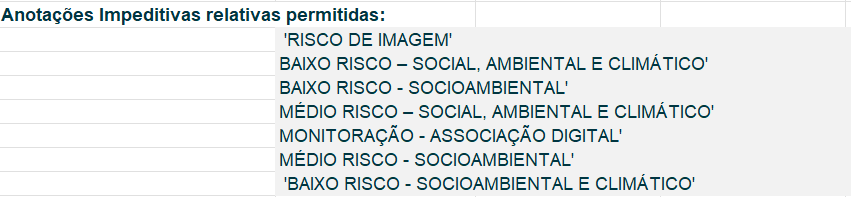

A flexibilização destas anotações já está sendo usada na Política de Crédito atual.

In [104]:
## Anotações restritivas
## Excluir anotações restritivas flexibilizadas na política 
anot = anot.loc[~anot['Descrição Tipo Anotação'].isin(["RISCO DE IMAGEM", "BAIXO RISCO - SOCIOAMBIENTAL", "MÉDIO RISCO - SOCIOAMBIENTAL", "MONITORAÇÃO - ASSOCIAÇÃO DIGITAL"])]
# agrupar CPF_CNPJ do dataframe anot
anot = anot.groupby("CPF_CNPJ").agg(
    quantidade = ("CPF_CNPJ" , "count")

)
# cruzar anotações com a base de dados 
base = base.merge(anot, left_on = 'CPF_CNPJ', right_on = 'CPF_CNPJ', how = 'left')
base['quantidade'] = base['quantidade'].fillna(0)
# filtrar cooperados com restrições 
base = base.loc[base['quantidade'] == 0]

# total de cooperados:
print(f"Quantidade total: {len(base)}")

Quantidade total: 20385


## Nível de risco do cooperado CRL 
Mantendo as regras da Política de Crédito atual, o cooperado tem que estar com CRL ativo classificado até o R7. Para o Cooperado PJ, não vamos trabalhar com o cooperado R7

In [105]:
# Criar merge do CFP com os dados da base 
base = base.merge(crl, left_on = 'CPF_CNPJ', right_on = 'CPF_CNPJ', how = 'left')
# mante somente cooperados com crl vigente
base = base.loc[base['Situacao_Limite'] == 'VIGENTE']
# selecionar cooperados até o R7
base  = base.loc[base['Risco_CRL'].isin(['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7'])]

# total de cooperados:
print(f"Quantidade total: {len(base)}")

Quantidade total: 17648


# comprometimento de renda no scr
Os dados do SCR de curo prazo foram inseridos para calcular o comprometimento do cooperado no curto prazo. o calculo do comprometimento é o valor total do endividamento do cooperado no SCR até 365 dias dividido por 12  (endividamento médio mensal) e dividido pela renda cadastrada.

In [106]:
# cruzar dados da base com o scr 
base = base.merge(scr, left_on = 'CPF_CNPJ', right_on = 'CPF_CNPJ', how = 'left')
# criar coluna de comprometimento de renda sendo a o valor do saldo devedor no SCR dividido por 12 e pela renda mensal 
base['comprometimento_renda'] = (base['Valor_A_Vencer_Ate_360_Dias_SFN'] / 12 / base['Renda_Bruta_Mensal'])*100
# substituir valores missing por 0,01
base['commprometimento_renda'] = base['comprometimento_renda'].fillna(0.01)

base

,CPF_CNPJ,Data_Matricula,Sigla_Tipo_Pessoa,Renda_Bruta_Mensal,Idade,Numero_PA_x,Data_Ultima_Renovacao_Cadastral,Data_Ultima_Atualização_Renda,Tipo_Renda,Vinculo_Empregaticio,...,Situacao_Limite,Data_Aprovacao_Limite,Data_Vigencia_Limite,Risco_CRL,Nivel_Risco_Cliente,Usuario_Alteracao_Limite,Usuario_Classificacao_Risco,Valor_A_Vencer_Ate_360_Dias_SFN,comprometimento_renda,commprometimento_renda
0,87237415115,2007-11-20,PF,52805.37,44,13,2023-05-30,2025-01-22,SALÁRIO,PROFISSIONAL LIBERAL ...,...,VIGENTE,2024-07-12,2025-07-07,R3,A,NAO CADASTRADO,NAO CADASTRADO,119950.35,18.929633,18.929633
1,28143337120,2020-01-03,PF,205658.30,62,13,2025-01-16,2025-01-16,AGROPECUÁRIA,PRODUTORES RURAIS ...,...,VIGENTE,2024-07-12,2025-07-07,R2,A,NAO CADASTRADO,NAO CADASTRADO,202634.96,8.210827,8.210827
2,75628457191,2023-10-26,PF,37666.20,30,117,2023-10-26,2024-08-21,OUTROS,AUTÔNOMO ...,...,VIGENTE,2025-02-08,2026-02-03,R4,B,RECLASSIFICAÇÃO AUTOMÁTICA,RECLASSIFICAÇÃO AUTOMÁTICA,31568.31,6.984226,6.984226
3,95612467168,2023-11-06,PF,1788.83,42,68,2023-11-06,2023-11-06,SALÁRIO,EMPREGADOS DE EMPRESAS PRIVADAS ...,...,VIGENTE,2025-02-08,2026-02-03,R6,C,RECLASSIFICAÇÃO AUTOMÁTICA,RECLASSIFICAÇÃO AUTOMÁTICA,19780.73,92.149291,92.149291
4,48027128000175,2022-12-27,PJ,276335.88,2,106,2024-12-02,2024-12-02,FATURAMENTO,NÃO SE APLICA,...,VIGENTE,2024-11-23,2025-11-18,R6,C,RECLASSIFICAÇÃO AUTOMÁTICA,RECLASSIFICAÇÃO AUTOMÁTICA,74000.95,2.231612,2.231612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17643,48726900000147,2022-12-09,PJ,67614.61,2,4,2024-02-09,2023-10-04,DECLARAÇÃO DE FATURAMENTO,NÃO SE APLICA,...,VIGENTE,2024-11-23,2025-03-23,R2,A,RECLASSIFICAÇÃO AUTOMÁTICA,RECLASSIFICAÇÃO AUTOMÁTICA,NaN,NaN,0.010000
17644,45795393894,2024-04-10,PF,4537.27,27,43,2024-05-01,2024-04-04,SALÁRIO,EMPREGADOS DE EMPRESAS PRIVADAS ...,...,VIGENTE,2024-11-23,2025-03-23,R7,C,RECLASSIFICAÇÃO AUTOMÁTICA,RECLASSIFICAÇÃO AUTOMÁTICA,15167.44,27.857133,27.857133
17645,03848626160,2014-12-22,PF,7758.73,32,11,2021-11-09,2024-10-21,SALÁRIO,EMPREGADOS DE EMPRESAS PRIVADAS ...,...,VIGENTE,2024-03-14,2025-03-09,R3,A,NAO CADASTRADO,NAO CADASTRADO,NaN,NaN,0.010000
17646,48743285000187,2023-12-15,PJ,5000.00,2,97,2023-12-14,2023-12-14,DECLARAÇÃO DE FATURAMENTO,NÃO SE APLICA,...,VIGENTE,2025-01-18,2025-05-18,R4,B,RECLASSIFICAÇÃO AUTOMÁTICA,RECLASSIFICAÇÃO AUTOMÁTICA,NaN,NaN,0.010000


## Simulador comprometimento de renda

Os perfis foram divididos em 3 grupoas quanto a classificação da renda

In [107]:
# criar função para distribuição do comprometimento máximo conforme o risco do CRL
def comprometimento_máximo(df, comp_r1_r3, comp_r4_r5, comp_r6_r7, perfil1, perfil2, perfil3):
    if df['Risco_CRL'] in ['R1', 'R2', 'R3'] and df['comprometimento_renda'] <= comp_r1_r3:
        return perfil1
    elif df['Risco_CRL'] in ['R4', 'R5'] and df['comprometimento_renda'] <= comp_r4_r5:
        return perfil2
    elif df['Risco_CRL'] in ['R6', 'R7'] and df['comprometimento_renda'] <= comp_r6_r7:
        return perfil3
    else:
        return "excluir"
    
    # criar função para distribuição do comprometimento máximo conforme o risco do CRL para pessoa jurídica
def comprometimento_máximo_pj(df, comp_r1_r3, comp_r4_r5, comp_r6_r7, perfil1, perfil2, perfil3):
    if df['Risco_CRL'] in ['R1', 'R2', 'R3', 'R4'] and df['comprometimento_renda'] <= comp_r1_r3:
        return perfil1
    elif df['Risco_CRL'] == 'R5' and df['comprometimento_renda'] <= comp_r4_r5:
        return perfil2
    elif df['Risco_CRL'] == 'R7' and df['comprometimento_renda'] <= comp_r6_r7:
        return perfil3
    else:
        return "excluir"

### Perfil médico:

In [108]:
#médico:
# Seleção do médico : é o cooperado cadastrado como profissional liberal
s1 = base.loc[base['Vinculo_Empregaticio'] == 'PROFISSIONAL LIBERAL                                                                                ']

In [109]:
# aplicar função:
s1['validacao_comprometimento'] = s1.apply(comprometimento_máximo, comp_r1_r3 = 75, comp_r4_r5 = 70, comp_r6_r7 = 65, axis = 1, perfil1 = 'P2.Médico 1', 
                                           perfil2 = 'P2.Médico 2', perfil3 = 'P3.Médico 3')
s1 = s1.loc[s1['validacao_comprometimento'] != 'excluir']
# agrupar por perfil 
perfil1 = s1.groupby('validacao_comprometimento').agg(
    quantidade = ('CPF_CNPJ', 'count')
)
print(perfil1)
print(sum(perfil1['quantidade']))

                           quantidade
validacao_comprometimento            
P2.Médico 1                      1330
P2.Médico 2                       578
P3.Médico 3                       138
2046


C:\Users\fabio.varriano\AppData\Local\Temp\ipykernel_18636\91614349.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s1['validacao_comprometimento'] = s1.apply(comprometimento_máximo, comp_r1_r3 = 75, comp_r4_r5 = 70, comp_r6_r7 = 65, axis = 1, perfil1 = 'P2.Médico 1',



* Ao selecionar os comprometimentos: 60, 57 e 55 . resultam em 1.973 cooperados enquadrados. (este é o mesmo padrão do perfil na política vigente. Ao selecionar os comprometimentos 70, 65 e 60 = 2025. O segundo modelo mais expansivo é importante, pois a inadimplência do perfil é muito baixa.


### Perfil PF 1 2 3

São cooperados com mais de 30 anos de idade e mais 3 anos de associação 

In [110]:
# Selecionar base de cooperados nos critérios de perfil 1 2 e 3
s2 = base[(base['Idade'] > 30) & (base['Data_Matricula'] < "2022-02-24")]
# excluir cooperados médicos:
s2 = s2.loc[s2['Vinculo_Empregaticio'] != 'PROFISSIONAL LIBERAL                                                                                ']
# tipo de pessoa = pf
s2 = s2.loc[s2['Sigla_Tipo_Pessoa'] == 'PF']

In [111]:
s2['validacao_comprometimento'] = s2.apply(comprometimento_máximo, comp_r1_r3 = 60, comp_r4_r5 = 55, comp_r6_r7 = 50, axis = 1,
                                           perfil1 = 'P2.Perfil PF-1', perfil2 = 'P2.Perfil PF-2', perfil3 = 'P2.Perfil PF=3')
s2 = s2.loc[s2['validacao_comprometimento'] != 'excluir']
# agrupar por perfil 
perfil2 = s2.groupby('validacao_comprometimento').agg(
    quantidade = ('CPF_CNPJ', 'count')
)
print(perfil2)
print(sum(perfil2['quantidade']))

                           quantidade
validacao_comprometimento            
P2.Perfil PF-1                   1709
P2.Perfil PF-2                   1095
P2.Perfil PF=3                    173
2977


### Perfis PF 4 5 6

São coooperados com menos de 30 anos de idade, porém, associados na cooperativa há mais de 3 anos

In [112]:
# Selecionar base de cooperados nos critérios de perfil 1 2 e 3
s3 = base[(base['Idade']  <= 30) & (base['Data_Matricula'] < "2022-02-24")]
# excluir cooperados médicos:
s3 = s3.loc[s3['Vinculo_Empregaticio'] != 'PROFISSIONAL LIBERAL                                                                                ']
s3 = s3.loc[s3['Sigla_Tipo_Pessoa'] == 'PF']

In [113]:
s3['validacao_comprometimento'] = s3.apply(comprometimento_máximo, comp_r1_r3 = 45, comp_r4_r5 = 37, comp_r6_r7 = 35, axis = 1, 
                                           perfil1 = 'P2.Perfil PF-4', perfil2 = 'P2.Perfil PF-5', perfil3 = 'P2.Perfil PF-6')
s3 = s3.loc[s3['validacao_comprometimento'] != 'excluir']
# agrupar por perfil 
perfil3 = s3.groupby('validacao_comprometimento').agg(
    quantidade = ('CPF_CNPJ', 'count')
)
print(perfil3)
print(sum(perfil3['quantidade']))

                           quantidade
validacao_comprometimento            
P2.Perfil PF-4                    120
P2.Perfil PF-5                    127
P2.Perfil PF-6                     34
281


### Perfis PF 7 8 9

São cooperados com mais de 30 anos e menos de 3 anos de associação

In [114]:
# Selecionar cooperados com mais dos perfis 7 8 9:
s4 =  base[(base['Idade']  > 30) & (base['Data_Matricula'] > "2022-02-24")]
# excluir cooperados médicos:
s4 = s4.loc[s4['Vinculo_Empregaticio'] != 'PROFISSIONAL LIBERAL                                                                                ']
s4 = s4.loc[s4['Sigla_Tipo_Pessoa'] == 'PF']


In [115]:
s4['validacao_comprometimento'] = s4.apply(comprometimento_máximo, comp_r1_r3 = 30, comp_r4_r5 = 25, comp_r6_r7 = 20, axis = 1, 
                                           perfil1 = 'P2.Perfil PF-7', perfil2 = 'P2.Perfil PF-8', perfil3 = 'P3.Perfil PF-9')
s4 = s4.loc[s4['validacao_comprometimento'] != 'excluir']
# agrupar por perfil 
perfil4 = s4.groupby('validacao_comprometimento').agg(
    quantidade = ('CPF_CNPJ', 'count')
)
print(perfil4)
print(sum(perfil4['quantidade']))

                           quantidade
validacao_comprometimento            
P2.Perfil PF-7                    648
P2.Perfil PF-8                    782
P3.Perfil PF-9                    303
1733


### Perfis 10 11 12 

é o perfil mais arriscado : cooperados com menos de 30 anos e menos de 3 anos de associação 

In [116]:
s5 =  base[(base['Idade']  <= 30) & (base['Data_Matricula'] > "2022-02-24")]
# excluir cooperados médicos:
s5 = s5.loc[s5['Vinculo_Empregaticio'] != 'PROFISSIONAL LIBERAL                                                                                ']
s5 = s5.loc[s5['Sigla_Tipo_Pessoa'] == 'PF']

In [117]:
s5['validacao_comprometimento'] = s5.apply(comprometimento_máximo, comp_r1_r3 =30, comp_r4_r5 = 20, comp_r6_r7 = 15, axis = 1, 
                                           perfil1 = 'P2.Perfil PF-10', perfil2 = 'P2.Perfil PF-11', perfil3 = 'P3.Perfil PF-12')
s5 = s5.loc[s5['validacao_comprometimento'] != 'excluir']
# agrupar por perfil 
perfil5 = s5.groupby('validacao_comprometimento').agg(
    quantidade = ('CPF_CNPJ', 'count')
)
print(perfil5)
print(sum(perfil5['quantidade']))

                           quantidade
validacao_comprometimento            
P2.Perfil PF-10                   124
P2.Perfil PF-11                   157
P3.Perfil PF-12                   129
410


### Perfis PJ 1 2 3
Pessoa jurídica, com mais de 3 anos de associação e faturamento - Não tolera o PA 97

In [118]:
s6 = base.loc[base['Sigla_Tipo_Pessoa'] == 'PJ']
s6 = s6.loc[s6['Data_Matricula'] < "2022-02-24"]
s6 = s6.loc[s6['Tipo_Renda']== 'FATURAMENTO']
# não tolera o PA 97:
s6 = s6.loc[s6['Numero_PA_x'] != 97]

In [126]:
s6['validacao_comprometimento'] = s6.apply(comprometimento_máximo_pj, comp_r1_r3 =40, comp_r4_r5 = 35, comp_r6_r7 = 30, axis = 1, 
                                           perfil1 = 'P2.Perfil PJ-1', perfil2 = 'P2.Perfil PJ-2', perfil3 = 'P3.Perfil PJ-3')
s6 = s6.loc[s6['validacao_comprometimento'] != 'excluir']
# agrupar por perfil 
perfil6 = s6.groupby('validacao_comprometimento').agg(
    quantidade = ('CPF_CNPJ', 'count')
)
print(perfil6)
print(sum(perfil6['quantidade']))

                           quantidade
validacao_comprometimento            
P2.Perfil PJ-1                    179
P2.Perfil PJ-2                    211
P3.Perfil PJ-3                     37
427


### Perfis PJ 4 5 6 
São cooperados em que é permitido a declaração de fauturamento 

In [120]:
s7 = base.loc[base['Sigla_Tipo_Pessoa'] == 'PJ']
s7 = s7.loc[s7['Data_Matricula'] < "2022-02-24"]
s7 = s7.loc[s7['Tipo_Renda']!= 'FATURAMENTO']
# não tolera o PA 97:
s7 = s7.loc[s7['Numero_PA_x'] != 97]

In [127]:
s7['validacao_comprometimento'] = s7.apply(comprometimento_máximo_pj, comp_r1_r3 =25, comp_r4_r5 = 20, comp_r6_r7 = 15, axis = 1,
                                           perfil1 = 'P2.Perfil PJ=4', perfil2 = 'P2.Perfil PJ=5', perfil3 = 'P3.perfil PJ=6')
s7 = s7.loc[s7['validacao_comprometimento'] != 'excluir']
# agrupar por perfil 
perfil7 = s7.groupby('validacao_comprometimento').agg(
    quantidade = ('CPF_CNPJ', 'count')
)
print(perfil7)
print(sum(perfil7['quantidade']))

                           quantidade
validacao_comprometimento            
P2.Perfil PJ=4                    596
P2.Perfil PJ=5                    550
P3.perfil PJ=6                     87
1233


## Perfis pj 7 8 9 

Cooperados pj com faturamento comprovado (simples = DASN) e que se associaram entre 6 meses e 3 anos 

In [122]:
s8 = base.loc[base['Sigla_Tipo_Pessoa'] == 'PJ']
s8 = s8.loc[s8['Data_Matricula'] > "2022-02-24"]
s8 = s8.loc[s8['Tipo_Renda']== 'FATURAMENTO']
# não tolera o PA 97:
s8 = s8.loc[s8['Numero_PA_x'] != 97]

In [128]:
s8['validacao_comprometimento'] = s8.apply(comprometimento_máximo_pj, comp_r1_r3 =15, comp_r4_r5 = 10, comp_r6_r7 = 7, axis = 1,
                                           perfil1 = 'P2.Perfil PJ-7', perfil2 = 'P2.Perfil PJ-8', perfil3 = 'P3.Perfil PJ-9')
s8 = s8.loc[s8['validacao_comprometimento'] != 'excluir']
# agrupar por perfil 
perfil8 = s8.groupby('validacao_comprometimento').agg(
    quantidade = ('CPF_CNPJ', 'count')
)
print(perfil8)
print(sum(perfil8['quantidade']))

                           quantidade
validacao_comprometimento            
P2.Perfil PJ-7                    115
P2.Perfil PJ-8                    177
P3.Perfil PJ-9                     42
334


## Resumo total 

In [129]:
#concatenar:
df_total = pd.concat([perfil1, perfil2, perfil3, perfil4, perfil5, perfil6, perfil7, perfil8])
df_total


,quantidade
validacao_comprometimento,
P2.Médico 1,1330
P2.Médico 2,578
P3.Médico 3,138
P2.Perfil PF-1,1709
P2.Perfil PF-2,1095
P2.Perfil PF=3,173
P2.Perfil PF-4,120
P2.Perfil PF-5,127
P2.Perfil PF-6,34


In [131]:
# total de cooperados enquadrados
print('Total de cooperados enquadrados: ' , sum(df_total['quantidade']))

Total de cooperados enquadrados:  9441


### Resultado das simulações:

* Se utilizar o cadastro 12 meses:  haverá 7.725 cooperados enquadrados;
* se utilizar o cadastro 18 meses: haverá 9.441 coopperados enquadrados - (utilizado na simulação)
* se utilizar o cadastro 24 meses : haverá 11.505 cooperados enquadrados;

Foi utilizado na simulação um comprometimento de renda mais expandido para perfis que de cooperados que apresentam uma inadimplencia menor na Fábrica de Limites. Foi feito uma nova simuação com o comprometimento de renda mais expandido começando para o cooperado médico 75% de comprometimento de renda.

Considerar que hoje temos 12.745 cooperados com crédito disponível para contratação na Fábrica de Limites - crédito parcelado, ou seja, com esta nova Política de Crédito haverá uma redução de cooperados enquaddrados. Todavia, existe formas de melhorar o desempenho com a melhoria da qualidade cadastral e base cadastral atualizada.